In [1]:
# Random forest model for EMA crossover identifier
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
csv_path = Path('../Resources/ts_ema_all_new_features.csv')
csv_path

WindowsPath('../Resources/ts_ema_all_new_features.csv')

In [3]:
ts_file_df = pd.read_csv(csv_path, parse_dates=[['Date', 'Time']])
ts_file_df.tail()

,Date_Time,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,MidLine.1,FastEMA,SlowEMA,squeeze,emax_signal,emas_dist,delta_dist,ATR
19600,2021-01-13 14:00:00,139.86,139.97,139.60,139.75,82450,75845,140.07,138.21,139.14,140.31,137.97,139.14,139.66,139.50,0,0,0.1611,0.0031,0.4665
19601,2021-01-13 14:15:00,139.75,139.97,139.65,139.94,114553,112963,140.06,138.31,139.19,140.40,137.97,139.19,139.72,139.54,0,0,0.1766,0.0155,0.4380
19602,2021-01-13 14:30:00,139.93,140.05,139.88,139.99,171929,129750,140.08,138.37,139.23,140.49,137.96,139.23,139.77,139.58,0,0,0.1902,0.0135,0.4280
19603,2021-01-13 14:45:00,139.99,140.07,139.70,140.03,177208,169230,140.13,138.46,139.29,140.58,138.01,139.29,139.82,139.62,0,0,0.2009,0.0108,0.4155
19604,2021-01-13 15:00:00,140.02,140.79,139.97,140.35,634514,555765,140.26,138.51,139.38,140.71,138.06,139.38,139.93,139.69,0,0,0.2400,0.0391,0.4370


In [4]:
# set index as Date_Time and drop MidLine.1 column (it is a duplicate of MidLine)
ts_file_df.set_index(pd.to_datetime(ts_file_df['Date_Time'], infer_datetime_format=True), inplace=True)
ts_file_df.drop(columns=['Date_Time', 'MidLine.1'], inplace=True)
ts_file_df.head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,squeeze,emax_signal,emas_dist,delta_dist,ATR
Date_Time,,,,,,,,,,,,,,,,,,
2018-01-16 08:45:00,111.51,113.17,111.35,113.13,1148689,1783516,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0,0,0.0000,0.0000,0.0
2018-01-16 09:00:00,113.14,113.43,112.70,112.84,482444,571196,0.0,0.0,0.0,0.0,0.0,112.84,112.84,0,0,0.0000,0.0000,0.0
2018-01-16 09:15:00,112.85,112.85,112.16,112.42,450320,469772,0.0,0.0,0.0,0.0,0.0,112.76,112.80,0,0,-0.0458,0.0458,0.0
2018-01-16 09:30:00,112.42,112.79,112.33,112.66,302400,396757,0.0,0.0,0.0,0.0,0.0,112.74,112.79,0,0,-0.0521,0.0063,0.0
2018-01-16 09:45:00,112.66,112.67,112.27,112.34,278542,334117,0.0,0.0,0.0,0.0,0.0,112.66,112.75,0,0,-0.0907,0.0385,0.0


In [5]:
# Set a variable list of features to feed to our model

x_var_list = ['Open', 'High', 'Low', 'Close', 'Up', 'Down', 'kcup', 'kclo', 'MidLine', 'bbup', 'bblo', 'FastEMA', 'SlowEMA', 'emas_dist', 'delta_dist', 'ATR']
ts_file_df[x_var_list].head()

,Open,High,Low,Close,Up,Down,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,emas_dist,delta_dist,ATR
Date_Time,,,,,,,,,,,,,,,,
2018-01-16 08:45:00,111.51,113.17,111.35,113.13,1148689,1783516,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000,0.0000,0.0
2018-01-16 09:00:00,113.14,113.43,112.70,112.84,482444,571196,0.0,0.0,0.0,0.0,0.0,112.84,112.84,0.0000,0.0000,0.0
2018-01-16 09:15:00,112.85,112.85,112.16,112.42,450320,469772,0.0,0.0,0.0,0.0,0.0,112.76,112.80,-0.0458,0.0458,0.0
2018-01-16 09:30:00,112.42,112.79,112.33,112.66,302400,396757,0.0,0.0,0.0,0.0,0.0,112.74,112.79,-0.0521,0.0063,0.0
2018-01-16 09:45:00,112.66,112.67,112.27,112.34,278542,334117,0.0,0.0,0.0,0.0,0.0,112.66,112.75,-0.0907,0.0385,0.0


In [6]:
ts_file_df['Up/1000'] = ts_file_df['Up']/1000
ts_file_df['Down/1000'] = ts_file_df['Down']/1000

In [7]:
ts_file_df.drop(columns=['Up', 'Down'], inplace=True)
ts_file_df

,Open,High,Low,Close,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,squeeze,emax_signal,emas_dist,delta_dist,ATR,Up/1000,Down/1000
Date_Time,,,,,,,,,,,,,,,,,,
2018-01-16 08:45:00,111.51,113.17,111.35,113.13,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.0000,0.0000,0.0000,1148.689,1783.516
2018-01-16 09:00:00,113.14,113.43,112.70,112.84,0.00,0.00,0.00,0.00,0.00,112.84,112.84,0,0,0.0000,0.0000,0.0000,482.444,571.196
2018-01-16 09:15:00,112.85,112.85,112.16,112.42,0.00,0.00,0.00,0.00,0.00,112.76,112.80,0,0,-0.0458,0.0458,0.0000,450.320,469.772
2018-01-16 09:30:00,112.42,112.79,112.33,112.66,0.00,0.00,0.00,0.00,0.00,112.74,112.79,0,0,-0.0521,0.0063,0.0000,302.400,396.757
2018-01-16 09:45:00,112.66,112.67,112.27,112.34,0.00,0.00,0.00,0.00,0.00,112.66,112.75,0,0,-0.0907,0.0385,0.0000,278.542,334.117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13 14:00:00,139.86,139.97,139.60,139.75,140.07,138.21,139.14,140.31,137.97,139.66,139.50,0,0,0.1611,0.0031,0.4665,82.450,75.845
2021-01-13 14:15:00,139.75,139.97,139.65,139.94,140.06,138.31,139.19,140.40,137.97,139.72,139.54,0,0,0.1766,0.0155,0.4380,114.553,112.963
2021-01-13 14:30:00,139.93,140.05,139.88,139.99,140.08,138.37,139.23,140.49,137.96,139.77,139.58,0,0,0.1902,0.0135,0.4280,171.929,129.750


In [8]:
x_var_list_new = ['Open', 'High', 'Low', 'Close', 'kcup', 'kclo', 'MidLine', 'bbup', 'bblo', 'FastEMA', 'SlowEMA', 'emas_dist', 'delta_dist', 'ATR']
ts_file_df[x_var_list_new].head()

,Open,High,Low,Close,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,emas_dist,delta_dist,ATR
Date_Time,,,,,,,,,,,,,,
2018-01-16 08:45:00,111.51,113.17,111.35,113.13,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000,0.0000,0.0
2018-01-16 09:00:00,113.14,113.43,112.70,112.84,0.0,0.0,0.0,0.0,0.0,112.84,112.84,0.0000,0.0000,0.0
2018-01-16 09:15:00,112.85,112.85,112.16,112.42,0.0,0.0,0.0,0.0,0.0,112.76,112.80,-0.0458,0.0458,0.0
2018-01-16 09:30:00,112.42,112.79,112.33,112.66,0.0,0.0,0.0,0.0,0.0,112.74,112.79,-0.0521,0.0063,0.0
2018-01-16 09:45:00,112.66,112.67,112.27,112.34,0.0,0.0,0.0,0.0,0.0,112.66,112.75,-0.0907,0.0385,0.0


In [9]:
ts_file_df[x_var_list_new] = ts_file_df[x_var_list_new].shift(1)
ts_file_df.head

<bound method NDFrame.head of                        Open    High     Low   Close    kcup    kclo  MidLine  \
Date_Time                                                                      
2018-01-16 08:45:00     NaN     NaN     NaN     NaN     NaN     NaN      NaN   
2018-01-16 09:00:00  111.51  113.17  111.35  113.13    0.00    0.00     0.00   
2018-01-16 09:15:00  113.14  113.43  112.70  112.84    0.00    0.00     0.00   
2018-01-16 09:30:00  112.85  112.85  112.16  112.42    0.00    0.00     0.00   
2018-01-16 09:45:00  112.42  112.79  112.33  112.66    0.00    0.00     0.00   
...                     ...     ...     ...     ...     ...     ...      ...   
2021-01-13 14:00:00  140.17  140.23  139.81  139.84  140.07  138.10   139.08   
2021-01-13 14:15:00  139.86  139.97  139.60  139.75  140.07  138.21   139.14   
2021-01-13 14:30:00  139.75  139.97  139.65  139.94  140.06  138.31   139.19   
2021-01-13 14:45:00  139.93  140.05  139.88  139.99  140.08  138.37   139.23   
2021-01-13

In [10]:
ts_file_df.dropna(inplace=True)
ts_file_df.head()

,Open,High,Low,Close,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,squeeze,emax_signal,emas_dist,delta_dist,ATR,Up/1000,Down/1000
Date_Time,,,,,,,,,,,,,,,,,,
2018-01-16 09:00:00,111.51,113.17,111.35,113.13,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0,0,0.0000,0.0000,0.0,482.444,571.196
2018-01-16 09:15:00,113.14,113.43,112.70,112.84,0.0,0.0,0.0,0.0,0.0,112.84,112.84,0,0,0.0000,0.0000,0.0,450.320,469.772
2018-01-16 09:30:00,112.85,112.85,112.16,112.42,0.0,0.0,0.0,0.0,0.0,112.76,112.80,0,0,-0.0458,0.0458,0.0,302.400,396.757
2018-01-16 09:45:00,112.42,112.79,112.33,112.66,0.0,0.0,0.0,0.0,0.0,112.74,112.79,0,0,-0.0521,0.0063,0.0,278.542,334.117
2018-01-16 10:00:00,112.66,112.67,112.27,112.34,0.0,0.0,0.0,0.0,0.0,112.66,112.75,0,0,-0.0907,0.0385,0.0,227.242,225.156


In [11]:
# Construct training start and training end dates

training_start = ts_file_df.index.min().strftime(format='%Y-%m-%d')
training_end = '2019-01-11'

# Construct test start and test end dates

testing_start = '2019-01-12'
testing_end = '2019-06-12'

# Construct validating start and validating end dates

vali_start = '2019-06-13'
vali_end = '2020-01-12'

# Confirming training, testing and validating dates
print(f"Training Start: {training_start}")
print(f"Training End: {training_end}")
print(f"Testing Start: {testing_start}")
print(f"Testing End: {testing_end}")
print(f"validating Start: {vali_start}")
print(f"validating end: {vali_end}")

Training Start: 2018-01-16
Training End: 2019-01-11
Testing Start: 2019-01-12
Testing End: 2019-06-12
validating Start: 2019-06-13
validating end: 2020-01-12


In [12]:
# Construct the X_train and y_train datasets
X_train = ts_file_df[x_var_list_new][training_start:training_end]
y_train = ts_file_df['emax_signal'][training_start:training_end]

X_train.head()

,Open,High,Low,Close,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,emas_dist,delta_dist,ATR
Date_Time,,,,,,,,,,,,,,
2018-01-16 09:00:00,111.51,113.17,111.35,113.13,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0000,0.0000,0.0
2018-01-16 09:15:00,113.14,113.43,112.70,112.84,0.0,0.0,0.0,0.0,0.0,112.84,112.84,0.0000,0.0000,0.0
2018-01-16 09:30:00,112.85,112.85,112.16,112.42,0.0,0.0,0.0,0.0,0.0,112.76,112.80,-0.0458,0.0458,0.0
2018-01-16 09:45:00,112.42,112.79,112.33,112.66,0.0,0.0,0.0,0.0,0.0,112.74,112.79,-0.0521,0.0063,0.0
2018-01-16 10:00:00,112.66,112.67,112.27,112.34,0.0,0.0,0.0,0.0,0.0,112.66,112.75,-0.0907,0.0385,0.0


In [13]:
y_train.tail()

Date_Time
2019-01-11 14:00:00    0
2019-01-11 14:15:00    0
2019-01-11 14:30:00    0
2019-01-11 14:45:00    0
2019-01-11 15:00:00    0
Name: emax_signal, dtype: int64

In [14]:
# Construct the X test and y test datasets

X_test = ts_file_df[x_var_list_new][testing_start:testing_end]
y_test = ts_file_df['emax_signal'][testing_start:testing_end]

X_test.head()

,Open,High,Low,Close,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,emas_dist,delta_dist,ATR
Date_Time,,,,,,,,,,,,,,
2019-01-14 08:45:00,100.09,100.16,99.88,99.93,100.32,99.54,99.93,100.22,99.64,99.99,99.95,0.0365,0.0124,0.1930
2019-01-14 09:00:00,98.85,100.07,98.66,100.00,100.45,99.47,99.96,100.14,99.78,99.99,99.96,0.0345,0.0021,0.2460
2019-01-14 09:15:00,99.98,100.22,99.73,100.14,100.50,99.47,99.98,100.12,99.85,100.02,99.97,0.0476,0.0131,0.2565
2019-01-14 09:30:00,100.15,100.94,100.08,100.88,100.61,99.46,100.04,100.44,99.63,100.19,100.06,0.1370,0.0894,0.2860
2019-01-14 09:45:00,100.88,101.01,100.43,100.68,100.68,99.46,100.07,100.56,99.58,100.29,100.11,0.1778,0.0407,0.3050


In [15]:
y_test.head()

Date_Time
2019-01-14 08:45:00    0
2019-01-14 09:00:00    0
2019-01-14 09:15:00    0
2019-01-14 09:30:00    0
2019-01-14 09:45:00    0
Name: emax_signal, dtype: int64

In [16]:
# Construct the X valid and y validation datasets

X_vali = ts_file_df[x_var_list_new][vali_start:vali_end]
y_vali = ts_file_df['emax_signal'][vali_start:vali_end]

X_vali.head()

,Open,High,Low,Close,kcup,kclo,MidLine,bbup,bblo,FastEMA,SlowEMA,emas_dist,delta_dist,ATR
Date_Time,,,,,,,,,,,,,,
2019-06-13 08:45:00,109.01,109.30,109.00,109.27,109.66,108.71,109.18,109.44,108.92,109.19,109.36,-0.1641,0.0280,0.2375
2019-06-13 09:00:00,109.46,110.09,109.39,110.06,109.74,108.69,109.22,109.67,108.76,109.37,109.42,-0.0545,0.1096,0.2625
2019-06-13 09:15:00,110.07,110.16,109.69,109.85,109.79,108.69,109.24,109.76,108.71,109.46,109.46,0.0033,0.0578,0.2740
2019-06-13 09:30:00,109.85,109.99,109.43,109.43,109.81,108.69,109.25,109.78,108.72,109.46,109.46,-0.0006,0.0039,0.2790
2019-06-13 09:45:00,109.43,109.56,109.32,109.46,109.83,108.72,109.28,109.79,108.76,109.46,109.46,-0.0002,0.0005,0.2775


In [17]:
y_vali.tail()

Date_Time
2020-01-10 14:00:00    0
2020-01-10 14:15:00    0
2020-01-10 14:30:00    0
2020-01-10 14:45:00    0
2020-01-10 15:00:00    0
Name: emax_signal, dtype: int64

In [18]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=1)

In [19]:
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({0: 143, 1: 143})

In [20]:
# StandardScaler 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [21]:
# Creating the StandardScaler instant 
scaler = StandardScaler()

In [22]:
# Feeding StandardScaler for X_train, X_test, X_vali
X_scaler_train = scaler.fit(X_resampled)

In [23]:
# Scaling the data 
X_train_scaled = X_scaler_train.transform(X_resampled)

In [24]:
X_test_scaled = X_scaler_train.transform(X_test)

In [25]:
X_vali_scaled = X_scaler_train.transform(X_vali)

In [26]:
# Import SKLearn library and Classes
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [27]:
# Fit SKLearn regression with training datasets:
model = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=1)
model.fit(X_train_scaled, y_resampled)

RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=1)

In [28]:
# Make predictions of "y" values from the X_test dataset
predictions = model.predict(X_test_scaled)

In [29]:
# Assemble actual y_test with predicted values

compare_predict_df = y_test.to_frame()
compare_predict_df["predict_emax"] = predictions

compare_predict_df

,emax_signal,predict_emax
Date_Time,,
2019-01-14 08:45:00,0,0
2019-01-14 09:00:00,0,0
2019-01-14 09:15:00,0,0
2019-01-14 09:30:00,0,0
2019-01-14 09:45:00,0,0
...,...,...
2019-06-12 14:00:00,0,0
2019-06-12 14:15:00,0,0
2019-06-12 14:30:00,0,0


In [30]:
# Save the pre-trained model
from joblib import dump, load
dump(model, 'random_forest_model_emax_version2.joblib')

['random_forest_model_emax_version2.joblib']

In [31]:
X_test_scaled

array([[-1.79956096, -1.8461096 , -1.79827999, ...,  0.19948339,
        -0.69033157, -1.29724346],
       [-2.0277849 , -1.86281348, -2.02154926, ...,  0.19056647,
        -0.92617991, -0.92892128],
       [-1.81980663, -1.83497368, -1.82573113, ...,  0.2489723 ,
        -0.67430304, -0.85595179],
       ...,
       [-0.09340295, -0.133034  , -0.09081912, ..., -0.82328754,
        -0.44532407, -0.99494129],
       [-0.11180811, -0.15530584, -0.11644018, ..., -0.79609093,
        -0.83458832, -1.00189077],
       [-0.1338943 , -0.16829775, -0.12925071, ..., -0.81972077,
        -0.85290664, -0.99841603]])

In [32]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm)
cm_df

,0,1
0,2174,460
1,6,64


In [33]:
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
acc_score

0.8276627218934911

In [34]:
# Display results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score {acc_score}")
print(classification_report(y_test, predictions))

Confusion Matrix


,0,1
0,2174,460
1,6,64


Accuracy Score 0.8276627218934911
              precision    recall  f1-score   support

           0       1.00      0.83      0.90      2634
           1       0.12      0.91      0.22        70

    accuracy                           0.83      2704
   macro avg       0.56      0.87      0.56      2704
weighted avg       0.97      0.83      0.89      2704



In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

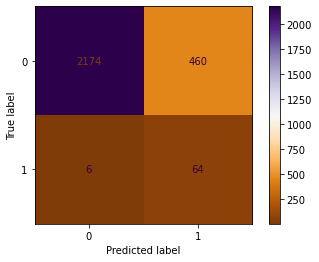

In [36]:
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='PuOr')

In [37]:
X_test_scaled_df = pd.DataFrame(X_test_scaled)
X_test_scaled_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.799561,-1.846110,-1.798280,-1.850745,-1.920435,-1.700439,-1.810055,-1.931183,-1.682427,-1.806979,-1.822936,0.199483,-0.690332,-1.297243
1,-2.027785,-1.862813,-2.021549,-1.837824,-1.896018,-1.712987,-1.804545,-1.946146,-1.657331,-1.806979,-1.821090,0.190566,-0.926180,-0.928921
2,-1.819807,-1.834974,-1.825731,-1.811983,-1.886627,-1.712987,-1.800872,-1.949887,-1.644783,-1.801462,-1.819244,0.248972,-0.674303,-0.855952
3,-1.788518,-1.701343,-1.761678,-1.675392,-1.865966,-1.714780,-1.789852,-1.890035,-1.684219,-1.770196,-1.802627,0.647559,1.072807,-0.650942
4,-1.654160,-1.688351,-1.697626,-1.712309,-1.852818,-1.714780,-1.784342,-1.867591,-1.693182,-1.751805,-1.793395,0.829464,-0.042321,-0.518902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,-0.148618,-0.162730,-0.121930,-0.137829,-0.134210,-0.031521,-0.081812,-0.105696,-0.058377,-0.113127,-0.068946,-1.110412,-0.335414,-0.925447
2700,-0.121011,-0.125610,-0.092649,-0.110142,-0.141723,-0.036899,-0.089159,-0.133752,-0.044037,-0.107609,-0.070792,-0.926278,-0.028582,-0.949770
2701,-0.093403,-0.133034,-0.090819,-0.128600,-0.149236,-0.040484,-0.094668,-0.152455,-0.036866,-0.107609,-0.072639,-0.823288,-0.445324,-0.994941
2702,-0.111808,-0.155306,-0.116440,-0.152596,-0.156749,-0.045862,-0.100178,-0.167418,-0.035074,-0.111288,-0.078177,-0.796091,-0.834588,-1.001891


In [38]:
from sklearn.metrics import precision_recall_curve

In [39]:
# Precision_Recall_curve 
probs_model = model.predict_proba(X_test_scaled)[:,1]
precision_model, recall_model, _ = precision_recall_curve(y_test, probs_model, pos_label=1)

In [40]:
import matplotlib.pyplot as plt

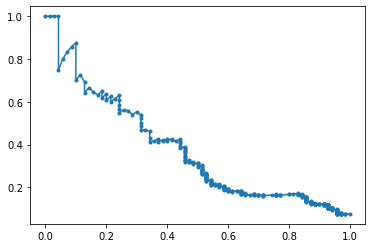

In [41]:
plt.plot(recall_model, precision_model, marker='.')

In [42]:
rf_model_importance = model.fit(X_train_scaled, y_resampled)

In [43]:
model_new = model.fit(X_train, y_train)
importance_new_model = rf_model_importance.feature_importances_

In [44]:
#List features in descending order by order of importance
#importance_rf_model = rf_model_importance.feature_importances_
importance_rf_model_sorted_des = sorted(zip(importance_new_model, X_train.columns), reverse=True)
importance_rf_model_sorted_des[:15]

[(0.26187033860044623, 'emas_dist'),
 (0.08313990811426268, 'delta_dist'),
 (0.06312168910896063, 'Close'),
 (0.059451155770484695, 'ATR'),
 (0.058676052788940815, 'High'),
 (0.05851078606956849, 'Low'),
 (0.05484614142087915, 'bbup'),
 (0.054037764192034814, 'kcup'),
 (0.05343578815906694, 'Open'),
 (0.05234313319932172, 'SlowEMA'),
 (0.05048719424958407, 'bblo'),
 (0.050237097136113074, 'MidLine'),
 (0.050211826734044514, 'FastEMA'),
 (0.049631124456292204, 'kclo')]

In [45]:
from sklearn.metrics import roc_curve, auc

# Calculate Area under the curve
# Making predictions to feed roc_curve module

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test_scaled)

# Calculate the ROC curve and AUC of the training set

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, train_predictions)
auc_train = auc(fpr_train, tpr_train)
auc_train = round(auc_train,4)
auc_train

1.0

In [46]:
# Calculate the ROC curve and AUC of the testing set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, test_predictions)
auc_test = auc(fpr_test, tpr_test)
auc_test = round(auc_test, 4)
auc_test

0.5071

In [47]:
Counter(y_train)

Counter({0: 6356, 1: 143})